# Question 1

## (a)

*Hint: use `seaborn.snsplot` to visualize data. use `np.corrcoef` to calculate the correlation matrix and use `seaborn.heatmap` to visualize the correlation matrix.*

/Users/pracheeti/anaconda3/envs/c142/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


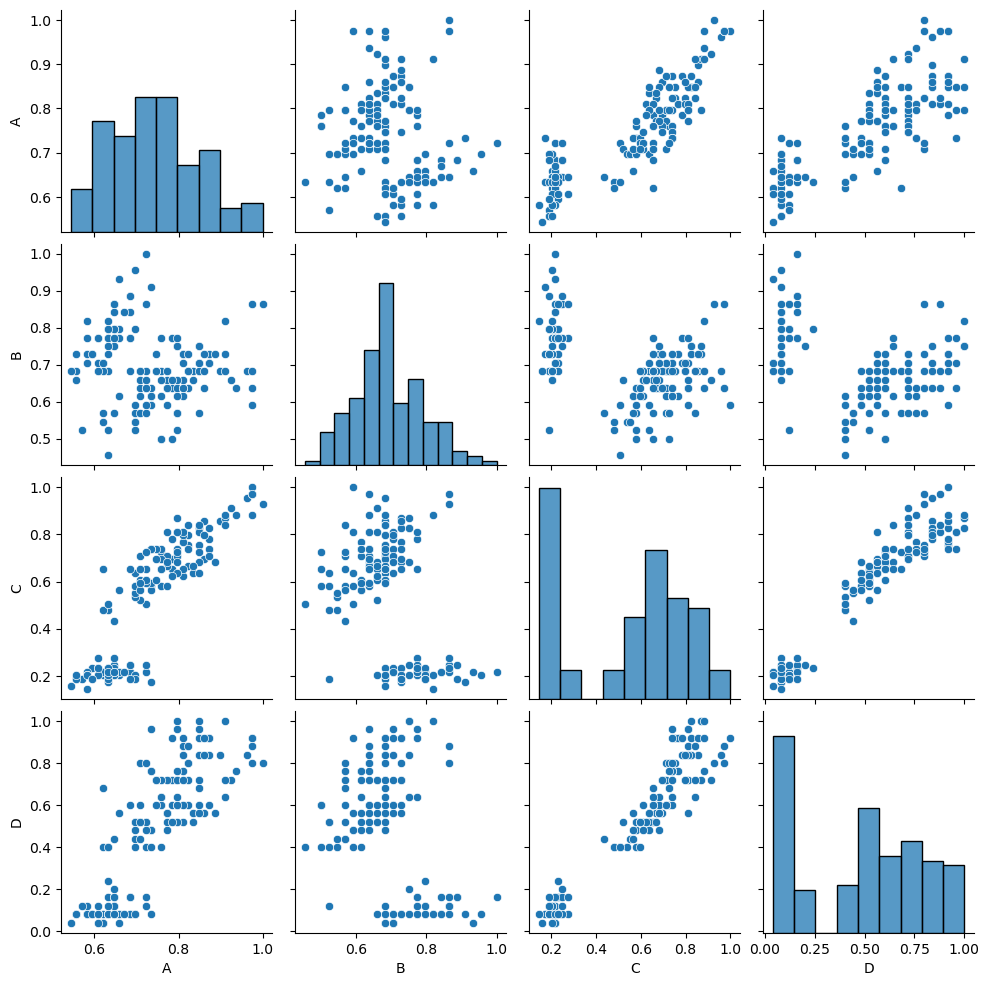

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df = pd.read_csv("compounds.csv")
features = df[["A", "B", "C", "D"]]
features_scaled = features.copy()

for f in features:
    max_val = features[f].max()
    features_scaled[f] = features[f] / max_val

# rescale the features
features_scaled

# visualize the data
sns.pairplot(data = features_scaled)

<Axes: >

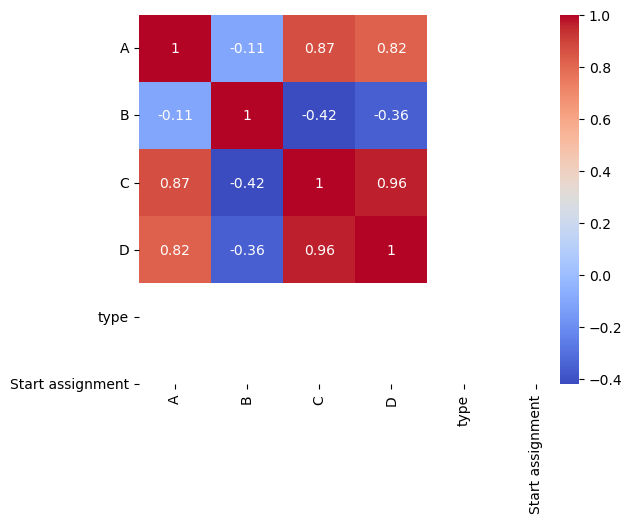

In [24]:
# determine which features are correlated
corrmat = np.corrcoef(features_scaled.T)
sns.heatmap(corrmat[:,:], cmap = 'coolwarm', xticklabels = df.columns[:], yticklabels = df.columns[:], annot = True) # redder colors are more highly correlated

Features C and D are highly correlated. Features A and C are the next most correlated. 

## (b)

### \[IMPORTANT\] Fill in and use the KMeans code below. DO NOT USE  `sklearn.cluster.KMeans`.

*Hint: To visualize the clusters, you can use `plt.scatter` and set the `c` parameters. Refer to Tutorial 5.*

In [110]:
import warnings
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


class KMeans():
    def __init__(self, n_clusters, max_iter=100):
        self.k = n_clusters
        self.max_iter = max_iter
    
    def cluster(self, X):
        """
        Do K-Means clustering
        
        Parameters
        ----------
        X: np.ndarray
            Normalized input features, shape (n_samples, n_features)
        """
        centroids = np.random.random((self.k, X.shape[1]))
        assignments = np.zeros(X.shape[0])
        new_assignments = self.create_new_assignments(centroids, X)
        
        # restart if run into bad initialization
        # Comment out this part for Q1.(d)
        if len(np.unique(new_assignments)) < self.k:
            return self.cluster(X)
        
        n_iters = 1
        while (new_assignments != assignments).any() and n_iters < self.max_iter:
            # compute centroids
            centroids = np.array([X[new_assignments == i].mean(axis=0) for i in range(self.k)])
            assignments = new_assignments
            # call the self.create_new_assignments
            new_assignments = self.create_new_assignments(centroids, X) 
            if len(np.unique(new_assignments)) < self.k:
                warnings.warn('Warning: At least one centroid vanishes')
            n_iters += 1
            if n_iters == self.max_iter:
                warnings.warn("Warning: Maximum number of iterations reached!")
        return new_assignments
            
        
    def create_new_assignments(self, centroids, X):
        """
        Assign each datapoint to its nearest centroid.
        
        Parameters
        ----------
        centroids: np.ndarray
            Centroid of each cluster, shape (n_clusters, n_features)
        X: np.ndarray
            Input features, shape (n_samples, n_features)
        
        Returns
        ------
        new_assignments: np.ndarray
            Index of cluster which each data point belongs to, shape (n_samples,)
        """
        # Compute the distances that stores the Eucledian distances between each datapoints and the centroid
        # shape (n_samples, n_clusters)
        # Hint: you can use cdist in scipy.spatial.distance. 
        # cdist doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        distances = cdist(X, centroids, metric='euclidean')
        new_assignments = np.argmin(distances, axis=-1)
        return new_assignments

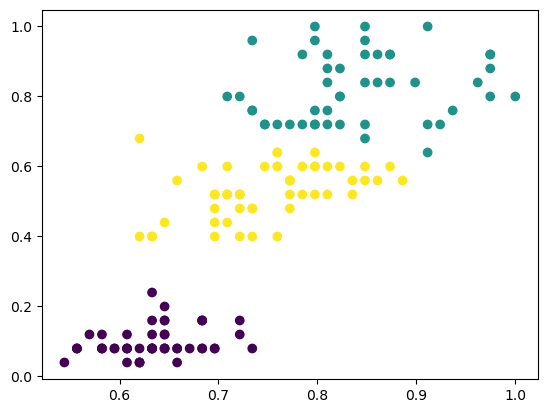

In [214]:
kmeans = KMeans(3)
assignments = kmeans.cluster(features_scaled)
assignments

plt.scatter(features_scaled["A"], features_scaled["D"], c = assignments)

For features A and D, 3 clusters make the most sense according to the visualization above, because we can see three distinct groups of data points. 

## (c)

### [IMPORTANT] Use the following function to validate your result. See the example in the docstring for usage.

*For debuuging: you will get output like (not the same as) this*:

```
Class 0 - amide: 48 out of 50 are classified correctly
Class 1 - ether: 46 out of 50 are classified correctly
Class 2 - phenol: 50 out of 50 are classified correctly
```

In [215]:
def validate(y_pred, y_true):
    """
    Validate the results of clustering
    
    Parameters
    ---------
    y_pred: np.ndarray
        Predicted clusters
    y_true: list or np.ndarray
        Ground truth clusters
    
    Example
    ------
    >>> validate(model.cluster(features), df['type'].values)
    """
    # correct classification
    compounds = np.unique(y_true) # should be ['amide','phenol','ether'] for compounds dataset
    clusters = [np.where(y_true == c)[0] for c in compounds]
    pred_class = np.unique(y_pred)
    
    #remove -1 for noise point in DBSCAN
    pred_class = np.delete(pred_class, np.where(pred_class == -1))
    assert len(pred_class) == len(compounds), \
        f'Predicted clusters has less or more than {len(compounds)} classes: {pred_class}'
    for i in range(3):
        #loop over solutions
        counts = []
        scores = []
        for j in range(3):
            # loop over clusters of true assignments
            sol_i = np.where(y_pred == pred_class[i])[0]
            counts.append(len(np.intersect1d(sol_i, clusters[j])))
            scores.append(counts[-1] / len(clusters[j]))
        idx = np.argmax(scores)
        print(
            f'Class {pred_class[i]} - {compounds[idx]}: {counts[idx]} out of {len(clusters[j])}'
            ' are classified correctly'
        ) 

In [216]:
validate(assignments, df["type"])

Class 0 - phenol: 50 out of 50 are classified correctly
Class 1 - ether: 46 out of 50 are classified correctly
Class 2 - amide: 48 out of 50 are classified correctly


The classification is quite accurate with 46-50 correct classifications out of 50.

## (d)

In [80]:
ntrials = 500
count = 0
for i in range(ntrials):
    kmeans = KMeans(4) # Comment out the re-init code in KMeans
    results = kmeans.cluster(features)
    if len(np.unique(results)) == 4:
        count += 1
print(f'Out of {ntrials} number of KMeans trials, only {count} gives 4 clusters')

/var/folders/zg/jkyklhtj37785k5v9s3wkb6m0000gp/T/ipykernel_28600/919561339.py:37: UserWarning: Warning: At least one centroid vanishes
  warnings.warn('Warning: At least one centroid vanishes')
/var/folders/zg/jkyklhtj37785k5v9s3wkb6m0000gp/T/ipykernel_28600/919561339.py:40: UserWarning: Warning: Maximum number of iterations reached!
  warnings.warn("Warning: Maximum number of iterations reached!")


Out of 500 number of KMeans trials, only 1 gives 4 clusters


With this code commented out, barely any of the KMeans trials results in 4 clusters. The initial choice of cetnroids plays an important role in how accurately and the final clusters form. Possible solutions to this would be to manually initilize the initial clusters or run multiple random initializations. 

# Question 2

## (a)

*Hint*:
+ Use `sklearn.cluster.DBSCAN` and adjust `eps`(Rcut) and `min_samples`(MinPts) parameters.**
+ Core points are stored in `core_sample_indices_` attribute.
+ Cluster results are stored in `labels_` attribute and noise points are labeled as -1.


In [104]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=10)
db.fit(features_scaled)
db.core_sample_indices_
db.labels_

array([ 0, -1,  2, -1,  2,  1, -1,  2,  0,  2,  0, -1,  1,  2,  1,  1,  3,
        2,  0,  1,  1,  3, -1,  3,  1,  2,  1,  1,  1,  3, -1,  1,  2,  1,
       -1,  0,  1,  3,  0,  1,  0,  0, -1,  3,  1,  0,  2,  3,  0, -1, -1,
        0, -1, -1,  2,  0, -1,  0,  2,  1,  1,  0,  1,  0,  2,  1,  0,  1,
        3,  0, -1,  1,  0,  3,  0,  1,  3,  0,  0,  0, -1,  1,  1, -1,  3,
        0, -1,  0,  0,  0,  0, -1,  1,  1,  1,  1,  3,  2,  3,  1, -1,  0,
        0,  0,  0,  1,  1,  1,  1,  0, -1,  1,  1, -1,  0,  2,  1,  1,  1,
       -1,  1,  1,  1,  0, -1, -1,  3, -1,  2,  1,  2,  0,  3,  0,  2, -1,
        1,  0,  1,  0,  2,  1,  0,  1,  0,  1,  3,  0,  0,  0])

In [107]:
core_points = sum((db.labels_ != -1) & (db.labels_ != 0))
border_points = sum(db.labels_ == 0)  # Border points have cluster label -1
noise_points = sum(db.labels_ == -1)  # Noise points have cluster label 0

print(f"Number of Core Points: {core_points}")
print(f"Number of Border Points: {border_points}")
print(f"Number of Noise Points: {noise_points}")

Number of Core Points: 81
Number of Border Points: 43
Number of Noise Points: 26


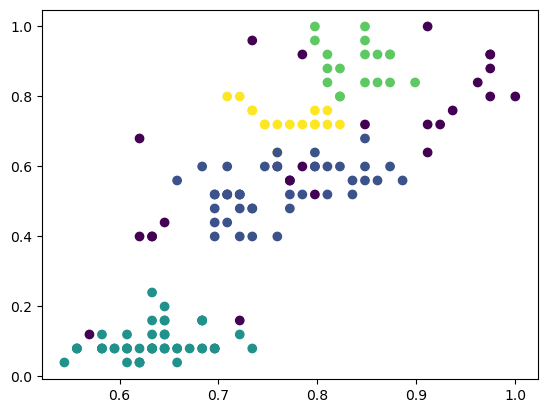

In [108]:
plt.scatter(features_scaled["A"], features_scaled["D"], c = db.labels_)

Compared to KMeans, DBSCAN is less effective. We can see from the visualiarion above that the clusters here are less distinct and are more intermixed. 

## (b)

*Hint: To visualize the clusters, you can use `plt.scatter` and set the `c` parameters. Refer to Tutorial 5.*

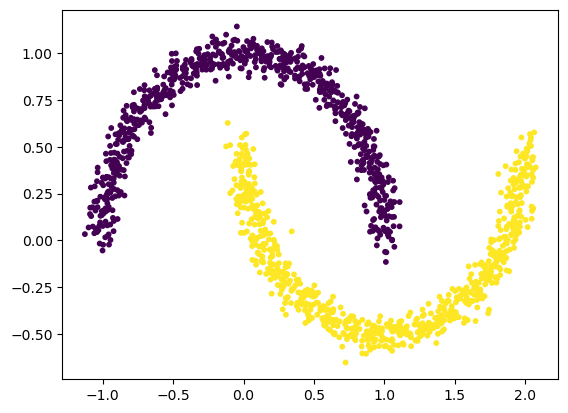

In [109]:
from sklearn import datasets

def moon_dataset(n_samples=1500):
    """
    Generate datasets. We choose the size big enough to see the scalability
    of the algorithms, but not too big to avoid too long running times
    
    Parameters
    ---------
    n_samples: int
        Number of data points
    
    Returns
    ------
    X: np.ndarray
        Data points, shape (n_samples, 2)
    y: np.ndarray
        Clusters that each point belongs to, shape (n_samples)
    """
    np.random.seed(0)
    n_samples = 1500
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
    X, y = noisy_moons
    return X, y

X, y = moon_dataset()
plt.scatter(X[:, 0], X[:, 1], s=10, c=y)

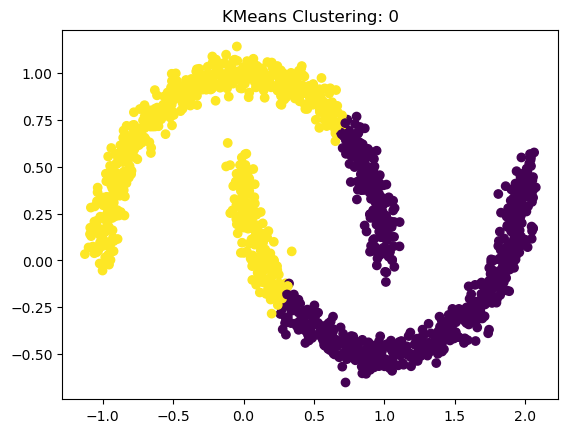

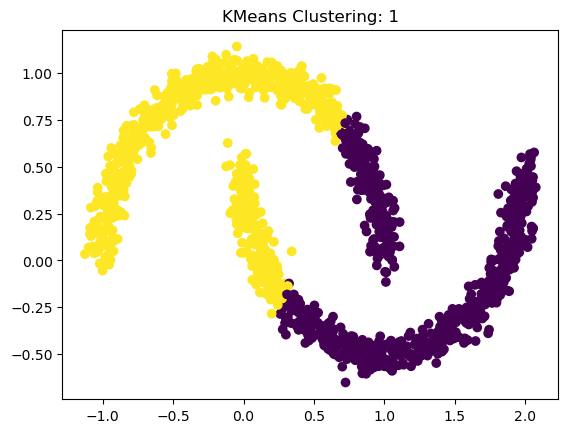

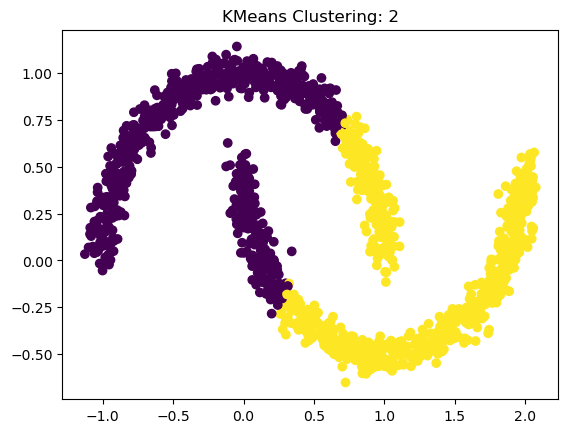

DBSCAN(eps=0.1, min_samples=10)

In [119]:
X, y = moon_dataset()

for i in range(3):
    kmeans_moon = KMeans(2)
    assignments = kmeans_moon.cluster(X)
    plt.scatter(X[:, 0], X[:, 1], c = assignments)
    plt.title(f'KMeans Clustering: {i}')
    plt.show()

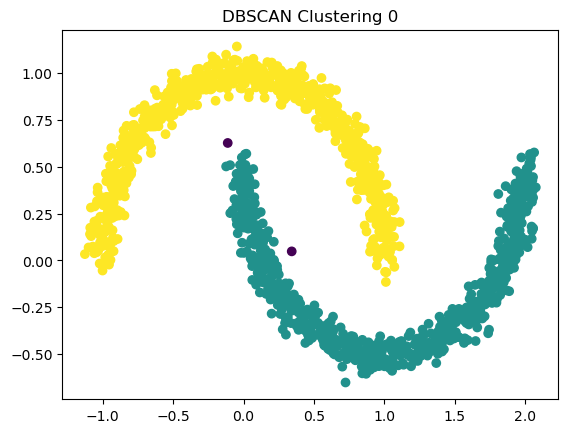

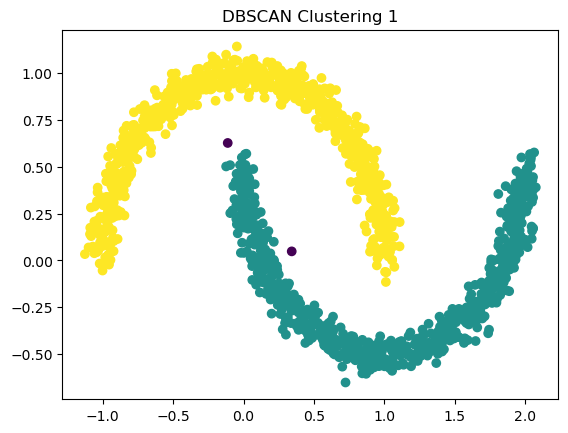

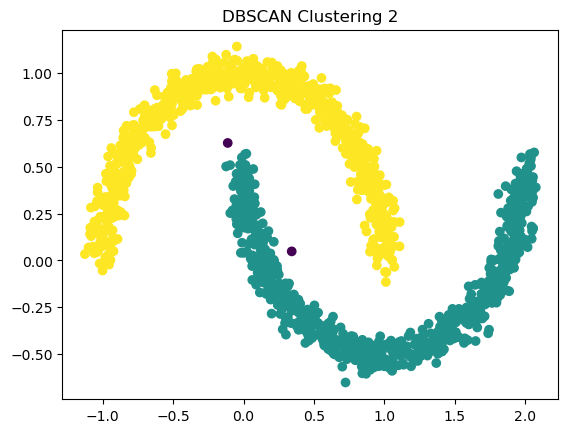

In [120]:
for i in range(3):
    db = DBSCAN(eps=0.1, min_samples=10)
    db.fit(X)
    plt.scatter(X[:, 0], X[:, 1], c = db.labels_)
    plt.title(f'DBSCAN Clustering {i}')
    plt.show()

DBSCAN works better on the moon dataset.

# Question 3

## (a)

In [127]:
# This time, normalize your chemical descriptor data for each attribute by subtracting off the mean and
# dividing by the standard deviation.

features_normalized = features.copy()
start_assignments = df["Start assignment"]

for f in features:
    max_val = features[f].max()
    std = features[f].std()
    features_normalized[f] = (features[f] - max_val) / std

features_normalized = pd.concat([features_normalized, start_assignments], axis=1)

## (b)

In [132]:
# Step 1: Separate Data into Clusters
clustered_data = {}
for cluster_label in range(3):
    cluster_data = features_normalized[features_normalized['Start assignment'] == cluster_label]
    clustered_data[cluster_label] = cluster_data

# Step 2: Calculate Centroid for Each Cluster
centroids = {}
centroid_vectors = {}
for cluster_label, cluster_data in clustered_data.items():
    features_in_cluster = cluster_data[["A", "B", "C", "D"]]
    centroid_vector = [features_in_cluster[f].mean() for f in features_in_cluster]
    centroid_vectors[cluster_label] = centroid_vector

# Display results
for cluster_label, centroid_vector in centroid_vectors.items():
    print(f"Centroid for Cluster {cluster_label + 1}: {centroid_vector}")

Centroid for Cluster 1: [-2.516707216474519, -3.159635548944422, -1.7886893420137298, -1.6667524028622307]
Centroid for Cluster 2: [-2.3742065199562874, -3.062770809487731, -1.6764711893778872, -1.6143388052879468]
Centroid for Cluster 3: [-2.560182005242792, -3.0904464493325, -1.875970127397162, -1.8344759150999395]


## (c)

*For debugging: should be 596.4585801741025*

In [172]:
# If you feel the code is slow in Q3(d), use numba to accelerate it
# import numba

# for each cluster, select the corresponding data, and calculate their distances to the centroid, 
# then sum them up. The centroids is a (n_cluster, n_feature) array, are centroids of each cluster.

# @numba.njit()
def cost_func(features, centroids, clusters):
    """
    Parameters
    ----------
    features: np.ndarray
        Feature matrix, shape (n_samples, n_features). In the compound dataset, n_features = 4.
    centroids: np.ndarray
        Centroids of each cluster, shape (n_cluster, n_features). In this question, n_cluster = 3.
    clusters: np.ndarray
        Cluster which each datapoint belongs to. shape (n_samples,)
    """
    n_samples, n_features = features.shape

    cost = 0.0

    for i in range(n_samples):
        cluster_idx = clusters[i]
        centroid = centroids[cluster_idx]
        feature_vector = features[i]
        cost += np.sum(np.square(feature_vector - centroid))

    return cost

In [173]:
centroids = []
for cluster_label, centroid_vector in centroid_vectors.items():
    centroids.append(centroid_vector)
    
features_normalized.shape
cost_func(features_normalized.values, centroids, df['Start assignment'].values)

592.4821896396086

## (d)

*For debugging*: 
+ Cooling schedule should be like: `array([500. , 499.5, 499.0005, ..., 3.37065784, 3.36728719, 3.3639199])`
+ Cost function can drop to around 540 (or even smaller).

In [231]:
import random
import numba

def SA(features, cluster, schedule, report_interval=100):
    """
    Simulated Annealing for clustering
    
    Parameters
    ----------
    features: numpy.ndarray
        Feature matrix. shape (n_samples, n_features)
    cluster: numpy.ndarray
        Initial guess of clusters. shape (n_samples,)
    schedule: numpy.ndarray
        Cooling schedule.
    report_interval: int
        Interval of steps to report result
    
    Returns
    ------
    res: dict
        Result containing the best clustering with the cost function value
    """
    
    centroids = np.array([np.mean(features[cluster == i], axis=0) for i in range(3)])
    cluster_eval = cost_func(features, centroids, cluster)
    
    best_cluster = cluster.copy()
    lowest_eval = cluster_eval

    for step, temp in enumerate(schedule):
        if step % report_interval == 0:
            print(step, temp, lowest_eval)
        for n in range(features.shape[0]):
            trial = cluster.copy()
            choices = [0, 1, 2]
            choices.remove(trial[n])
            rand_choice = random.sample(choices, 1)[0]
            trial[n] = rand_choice
            
            trial_centroids = np.array([np.mean(features[trial == i], axis=0) for i in range(3)])
            trial_eval = cost_func(features, trial_centroids, trial)
            if np.exp(-(cluster_eval - trial_eval) / temp) >= np.random.random():
                cluster = trial
                cluster_eval = trial_eval
                if trial_eval < lowest_eval:
                    best_cluster = cluster.copy()
                    lowest_eval = cluster_eval
                    
    return {"solution": best_cluster, "evaluation": lowest_eval}

In [232]:
def geometric_cooling(init_temp, num_steps, alpha):
    schedule = []
    schedule.append(init_temp)
    for i in range(num_steps):
        schedule.append(init_temp * alpha)
        init_temp = init_temp * alpha
    return schedule

In [233]:
for i in range(3):
    print(f"## Trial {i} ##")
    cooling_schedule = geometric_cooling(init_temp=500, num_steps=5000, alpha=0.999)
    res = SA(features_normalized.values, df['Start assignment'].values, cooling_schedule)
    validate(res["solution"], df['type'].values)

## Trial 0 ##
0 500 592.4821896396085
100 452.39607355685473 548.8193475055498
200 409.324414739318 548.8193475055498
300 370.3535160780496 548.8193475055498
400 335.0929530033702 548.8193475055498
500 303.1894724305924 543.5748220076841
600 274.3234537427483 537.2233650290149
700 248.20570671554952 537.2233650290149
800 224.57457430503766 537.2233650290149
900 203.19331127260224 537.2233650290149
1000 183.84771238548197 537.2233650290149
1100 166.34396643120385 537.2233650290149
1200 150.50671454669973 537.2233650290149
1300 136.17729340973847 537.2233650290149
1400 123.2121456923309 537.2233650290149
1500 111.4813818514512 537.2233650290149
1600 100.86747884857778 537.2233650290149
1700 91.26410276135128 537.2233650290149
1800 82.57504349184919 537.2233650290149
1900 74.71325089899814 537.2233650290149
2000 67.5999626987498 537.2233650290149
2100 61.163915395008495 537.2233650290149
2200 55.34063033613095 537.2233650290149
2300 50.07176774445401 537.2233650290149
2400 45.304542247283

The 3 solutions and the members of the phenol, ether, and amide types as part of each cluster can be seen above. This assignment does not perform as well as problem 1, with much lower classification accuracies. 